In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.links import caffe
from chainer.serializers import npz

In [3]:
## save caffemodel needed once
# caffemodel = caffe.CaffeFunction('../../Badmintion/VGG_CNN_M_2048.caffemodel')
# npz.save_npz('VGG_CNN_M_2048.npz', caffemodel, compression=False)

In [4]:
model_npz = np.load('../VGG_CNN_M_2048.npz')
print(model_npz.keys())

['conv3/W', 'conv3/b', 'fc8/W', 'fc8/b', 'conv1/W', 'conv1/b', 'conv2/W', 'conv2/b', 'conv5/W', 'conv5/b', 'fc6/W', 'fc6/b', 'conv4/W', 'conv4/b', 'fc7/W', 'fc7/b']


In [13]:
# define MyVGG
class VGG(chainer.Chain):
    def __init__(self, pretrained_model=model_npz):
        super(VGG, self).__init__()
        with self.init_scope():
            self.base = BaseVGG()
            self.fc6 = L.Linear(None, 4096)
            self.fc7 = L.Linear(4096, 2048)
        #npz.load_npz(pretrained_model, self.base)
            
    def __call__(self, x):
        h = self.predict(x)
        return h
        
    def predict(self, x):
        h = self.base(x)
        h = F.dropout(F.relu(self.fc6(h)), ratio=.5)
        h = F.dropout(F.relu(self.fc7(h)), ratio=.5)
        return h

In [14]:
# define VGG_CNN_M_2048
class BaseVGG(chainer.Chain):
    def __init__(self):
        super(BaseVGG, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels=96, ksize=7, stride=2)
            self.conv2 = L.Convolution2D(96, out_channels=256, ksize=5, stride=2)
            self.conv3 = L.Convolution2D(256, out_channels=512, ksize=3, pad=1)
            self.conv4 = L.Convolution2D(512, out_channels=512, ksize=3, pad=1)
            self.conv5 = L.Convolution2D(512, out_channels=512, ksize=3, stride=2)
            
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv3(h))
        
        h = F.relu(self.conv4(h))
        
        h = F.relu(self.conv5(h))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        return h

(224, 224, 3)
(1, 3, 224, 224)


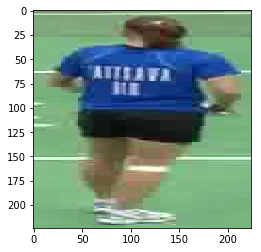

In [32]:
# 入力画像サイズの定義
image_shape = (224, 224)

# 画像を読み込み、RGB形式に変換する
image = Image.open('../data/0/img_007165.jpg').convert('RGB')
# 画像のリサイズとクリップ
image_w, image_h = image_shape
w, h = image.size
if w > h:
    shape = [image_w * w / h, image_h]
else:
    shape = [image_w, image_h * h / w]
x = (shape[0] - image_w) / 2
y = (shape[1] - image_h) / 2
image = image.resize(image_shape)
#image = image.crop((x, y, x + image_w, y + image_h)) # cropしない
pixels = np.asarray(image).astype(np.float32)
print(pixels.shape)


# pixelsは3次元でそれぞれの軸は[Y座標, X座標, RGB]を表す
# 入力データは4次元で[画像インデックス, BGR, Y座標, X座標]なので、配列の変換を行う
# RGBからBGRに変換する
pixels = pixels[:,:,::-1]

# 軸を入れ替える
pixels = pixels.transpose(2,0,1)

# 平均画像を引く
mean_image = np.ndarray((3, 224, 224), dtype=np.float32)
mean_image[0] = 103.939
mean_image[1] = 116.779
mean_image[2] = 123.68
pixels -= mean_image

# 4次元にする
pixels = pixels.reshape((1,) + pixels.shape)
plt.imshow(image)
print(pixels.shape)

In [37]:
# check the outputs of VGG
model = VGG()

y = model(pixels)
y

variable([[ 6.46849728,  0.        ,  0.        , ...,  3.33014894,
            0.        ,  7.67124844]])

In [ ]:
y = F.softmax(y).data
y.max(axis=1)

In [109]:
# disable to learn weght in baseVGG
model = VGG()
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)
model.base.disable_update()

In [119]:
y = model(pixels)
y = F.softmax(y).data
y.max(axis=1)

array([ 0.72818965], dtype=float32)

# load mat file

In [19]:
from scipy import io
import numpy as np
import pandas as pd

In [7]:
matfile = scipy.io.loadmat('/home/daichi/matlabfiles/ucf101-img-vgg16-split1.mat')

In [18]:
type(matfile["net"])

numpy.ndarray

In [48]:
matfile["net"][0][0][2]

array([[ (array(['conv1_1'], 
      dtype='<U7'), array(['dagnn.Conv'], 
      dtype='<U10'), array([[array(['input'], 
      dtype='<U5')]], dtype=object), array([[array(['x1'], 
      dtype='<U2')]], dtype=object), array([[array(['conv1_1f'], 
      dtype='<U8'),
        array(['conv1_1b'], 
      dtype='<U8')]], dtype=object), array([[ (array([[ 3,  3,  3, 64]], dtype=uint8), array([[1]], dtype=uint8), array([], shape=(0, 0), dtype=object), array([[1, 1, 1, 1]], dtype=uint8), array([[1, 1]], dtype=uint8))]], 
      dtype=[('size', 'O'), ('hasBias', 'O'), ('opts', 'O'), ('pad', 'O'), ('stride', 'O')])),
        (array(['relu1_1'], 
      dtype='<U7'), array(['dagnn.ReLU'], 
      dtype='<U10'), array([[array(['x1'], 
      dtype='<U2')]], dtype=object), array([[array(['x2'], 
      dtype='<U2')]], dtype=object), array([], shape=(0, 0), dtype=object), array([[ (array([[1]], dtype=uint8), array([[0]], dtype=uint8), array([], shape=(0, 0), dtype=object))]], 
      dtype=[('useShortCircu

# ED-TCN keras

define model

In [2]:
def channel_normalization(x):
    # Normalize by the highest activation
    max_values = max(abs(x), axis=2) + 1e-5
    out = x / max_values
    return out

In [19]:
a = np.zeros_like(pixels)
b = np.random.random(a.shape)

In [12]:
# model, param_str = tf_models.ED_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, activation='norm_relu', return_param_str=True) 
n_nodes = [64, 96]
conv = 25 # {'50Salads':25, "JIGSAWS":20, "MERL":5, "GTEA":25}
n_layers = len(n_nodes)

In [37]:
max_len = 10
max_len = int(np.ceil(max_len / (2**n_layers))) * (2**n_layers)
print(max_len)

12


In [86]:
len(y)

1

In [87]:
class ED_TCN(chainer.Chain):
    def __init__(self):#, n_nodes, conv_len, n_classes, n_feat, max_len):
        super(ED_TCN, self).__init__()
        with self.init_scope():
            # Encoder
            self.conv1 = L.ConvolutionND(ndim=1, in_channels=2048, out_channels=64, ksize=3, pad=0)
            self.conv2 = L.ConvolutionND(ndim=1, in_channels=64, out_channels=96, ksize=3, pad=0)
            
            # Decoder
            self.conv3 = L.ConvolutionND(ndim=1, in_channels=96, out_channels=64, ksize=3, pad=0)
            self.conv4 = L.ConvolutionND(ndim=1, in_channels=64, out_channels=96, ksize=3, pad=0)
            
            # output layer
            fc1 = L.Linear(in_size=64, out_size=10)
            
    def __call__(self, x):
        ## Encoder
        h = self.conv1(x)
        h = F.relu(F.dropout(h, ratio=0.3))
        h = F.max_pooling_nd(h)
        h = self.conv2(h)
        h = F.relu(F.dropout(h, ratio=0.3))
        h = F.max_pooling_nd(h)
        ## Decoder
        h = F.upsampling_2d(h, ksize=2)
        h = self.conv3(h)
        h = F.relu(F.dropout(h, ratio=0.3))
        h = F.upsampling_2d(h, ksize=2)
        h = F.relu(F.dropout(h, ratio=0.3))
        ## output
        h = self.fc1(h)
        h = F.softmax(h)
        return h

In [88]:
model = ED_TCN()
model(y)

InvalidType: 
Invalid operation is performed in: ConvolutionND (Forward)

Expect: in_types[1].ndim == 2
Actual: 3 != 2

implementation